# Supervised user based collaborative filtering

## Import Libraries

In [8]:
# Standard library imports
import os # allows access to OS-dependent functionalities
import re #  regular expression matching operations similar to those found in Perl
import sys # to manipulate different parts of the Python runtime environment
import warnings # is used to display the message Warning
import pickle # serializing and deserializing a Python object structure.

# Third party libraries
from fastparquet import write # parquet format, aiming integrate into python-based big data work-flows
from fuzzywuzzy import fuzz # used for string matching

import numpy as np # functions for working in domain of linear algebra, fourier transform, matrices and arrays
import pandas as pd # data analysis and manipulation tool
import joblib # set of tools to provide lightweight pipelining in Python
import glob

# visualization
import matplotlib.pyplot as plt # collection of functions that make matplotlib work like MATLAB.

# Surprise libraries
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import GridSearchCV, train_test_split, cross_validate
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering

# pip install git+https://github.com/NicolasHug/surprise.git

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# Get the current working directory
cwd = os.getcwd()

# Add the path of the utils directory to sys.path
utils_path = os.path.abspath(os.path.join(cwd, '..', 'utils'))
sys.path.append(utils_path)

# Utils libraries
from cleaning import *
from recommend import *
from testing import *
from training import *

#Preparing folder variables

main_folder = os.path.abspath(os.path.join(os.pardir))
data_folder = (main_folder + "/" +"data")
saved_models_folder = (data_folder + "/" + "saved_models")
raw_data = (data_folder + "/" + "_raw")
processed_data = (data_folder + "/" + "processed")
baseline_data = (saved_models_folder + "/" + "baseline")
test_models = (saved_models_folder + "/" + "test_models")

## Loading and cleaning data

In [2]:
# CSV file called "anime.csv" from a directory called raw_data and returns the contents as a Pandas DataFrame
anime = pd.read_csv(raw_data + "/" + "anime.csv") 

# CSV file called "rating.csv.zip" from a directory called raw_data and returns the contents as a Pandas DataFrame
rating = pd.read_csv(raw_data + "/" + "rating.csv.zip")

In [3]:
rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [4]:
rating.shape

(7813737, 3)

In [5]:
rating.describe()

,user_id,anime_id,rating
count,7.813737e+06,7.813737e+06,7.813737e+06
mean,3.672796e+04,8.909072e+03,6.144030e+00
std,2.099795e+04,8.883950e+03,3.727800e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.897400e+04,1.240000e+03,6.000000e+00
50%,3.679100e+04,6.213000e+03,7.000000e+00
75%,5.475700e+04,1.409300e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


In [ ]:
'''
This code calculates the data sparsity of a ratings DataFrame that has columns 
user_id, anime_id, and rating.
'''
# Filter out all ratings less than or equal to 0 and reset the index of the DataFrame
ratingdf = rating[rating.rating>0]
df = ratingdf.reset_index()

# Calculate the total number of interactions
num_interactions = df.shape[0]

# Calculate the total number of unique users and items
num_users = df['user_id'].nunique()
num_items = df['anime_id'].nunique()

# Calculate the number of missing interactions
num_missing_interactions = num_users * num_items - num_interactions

# Calculate the data sparsity
sparsity = num_missing_interactions / (num_users * num_items)

print(f'Total number of interactions: {num_interactions}')
print(f'Total number of unique users: {num_users}')
print(f'Total number of unique items: {num_items}')
print(f'Number of missing interactions: {num_missing_interactions}')
print(f'Data sparsity: {sparsity:.4f}')

Total number of interactions: 6337241
Total number of unique users: 69600
Total number of unique items: 9927
Number of missing interactions: 684581959
Data sparsity: 0.9908


In [ ]:
print(supervised_rating_cleaning.__doc__)

Imputing missing data may introduce bias into the dataset and therefore affect the predictions made by a recommendation system. It is generally recommended to avoid imputing missing data unless absolutely necessary.

Steps of supervised_rating_cleaning:
- selects only those rows from the 'rating' DataFrame where the value of the 'rating' column is greater than 0. The resulting DataFrame is assigned to the variable 'ratingdf'.
- resets the index of the 'ratingdf' DataFrame. This means that the current index is replaced with a sequential index starting from 0, and a new column called 'index' is added to the DataFrame to store the old index values.
- drops the 'index' column from the 'ratingdf' DataFrame. The 'axis=1' argument specifies that the column should be dropped, and 'inplace=True' means that the changes should be made to the DataFrame in place (i.e., the DataFrame is modified directly rather than creating a copy).
- returns the modified 'ratingdf' DataFrame as the output of the function.

In [6]:
# Cleaning the data
ratingdf = supervised_rating_cleaning(rating)

In [7]:
ratingdf.shape

(6337241, 3)

## Preparing the data for baseline

In here we are goin to prepare de data to be used in the model baseline.

To do a baseline we will use a smaller dataset and then use the whole dataset in the selected mode. Because using a smaller dataset for prototyping and testing can be a good way to quickly iterate and experiment with different algorithms and hyperparameters before scaling up to the full dataset.

In [48]:
def prepare_for_different_models():
    '''
    The code reads two CSV files (anime.csv and rating.csv.zip) and loads them into dataframes. 
    Then it creates a subset of the rating dataframe containing only rows where the rating is 
    greater than 0 and removes the index column. Next, it samples a subset of the data with 
    a specified size, grouped by the rating column.
    '''
    # Load 'anime.csv' file into a pandas DataFrame object called 'anime'
    anime = pd.read_csv(raw_data + "/" + "anime.csv")

    # Load 'rating.csv.zip' file into a pandas DataFrame object called 'rating'
    rating = pd.read_csv(raw_data + "/" + "rating.csv.zip")

    # Create a new DataFrame 'anime_mapping' that is a copy of the 'anime' DataFrame and remove the 'episodes', 'members', and 'rating' columns
    anime_mapping = anime.copy()
    anime_mapping.drop(['episodes','members','rating'],axis=1, inplace=True)

    # Filter out all ratings less than or equal to 0 and reset the index of the DataFrame
    ratingdf = rating[rating.rating>0]
    ratingdf = ratingdf.reset_index()

    # Drop the 'index' column and update the DataFrame in-place
    ratingdf.drop('index', axis=1, inplace=True)

    # Get the shape of the DataFrame 'ratingdf'
    ratingdf.shape

    # Set the size to 100,000 and sample from the 'ratingdf' DataFrame based on the proportion of ratings for each score
    size = 100000

    # This will make sure that the sampled data has roughly the same proportion of ratings for each score as the original data
    ratingdf_sample = ratingdf.groupby("rating", group_keys=False).apply(lambda x: x.sample(int(np.rint(size*len(x)/len(ratingdf))))).sample(frac=1).reset_index(drop=True)

    # Create a new 'Reader' object with the rating scale set to a range between 1 and 10
    reader = Reader(rating_scale=(1,10))

    # Load the sampled data into a 'Dataset' object using the 'load_from_df' method and the 'reader' object
    data = Dataset.load_from_df(ratingdf_sample[['user_id', 'anime_id', 'rating']], reader)

    # Saving the table to pickle
    joblib.dump(data,processed_data + "/" + "data_reader_for_different_models.pkl")

    return data
data = prepare_for_different_models()

## Model Baseline

The next function that performs cross-validation for several collaborative filtering algorithms using the Surprise library and returns the results in a pandas DataFrame. The function takes a Surprise dataset object as input and outputs two DataFrames, one with the results for each individual algorithm and another with the results for all algorithms.

The algorithms used in this function are SVD, SVD++, SlopeOne, NMF, NormalPredictor, BaselineOnly, and CoClustering. For each algorithm, the function performs 5-fold cross-validation and computes the RMSE, MSE, MAE, and FCP metrics. The results are then stored in a DataFrame and saved to a file.

Note that the function only runs the SVD algorithm by default. To run other algorithms, you need to uncomment the relevant lines in the for loop. Also, the function assumes that the saved_models_folder variable has been defined elsewhere in the code.

Overall, this function provides a basic implementation of collaborative filtering algorithms using the Surprise library and can be used as a starting point for building more sophisticated recommendation systems

In [51]:
from surprise.model_selection import KFold
'''
Function that runs several collaborative filtering algorithms on an input dataset using cross-validation 
and computes several evaluation metrics. The function loops through a list of algorithms, 
runs cross-validation with each algorithm, computes the mean evaluation results across all folds, 
and appends the results to an overall list of results. It then saves the evaluation results 
of each algorithm in a Parquet file and saves the overall evaluation results of all algorithms 
in another Parquet file. The function returns the overall evaluation results.
'''
def baseline_all(data):

    # instantiate the collaborative filtering algorithms we want to evaluate
    svd = SVD()
    svdp = SVDpp()
    slpo = SlopeOne()
    nm  = NMF()
    nmlp = NormalPredictor()
    #knnbase = KNNBaseline()
    #knnb = KNNBasic()
    #knnmean = KNNWithMeans()
    #knnzs = KNNWithZScore()
    baseonly = BaselineOnly()
    coclus = CoClustering()

    # loop through each algorithm and evaluate it using 5-fold cross-validation
    for algorithm in [svd,svdp,slpo,nm,nmlp,baseonly,coclus]:

        # create an empty list to hold the benchmark results for this algorithm
        benchmark_inndividual = []
        
        # print a message to indicate which algorithm is being evaluated
        print(algorithm,"started")

        folds = KFold(n_splits=5, shuffle=True, random_state=42)

        # run 5-fold cross-validation and compute RMSE, MSE, MAE, and FCP metrics
        results = cross_validate(algorithm, data, measures=['RMSE','MSE','MAE','FCP'], cv=folds, verbose=True)

        # print a message to indicate that the algorithm has finished evaluating
        print(algorithm,"finished")

        # calculate the mean of each metric over the 5 folds and store the results in a DataFrame
        tmp = pd.DataFrame.from_dict(results).mean(axis=0)

        # extract the name of the algorithm from the object and append it to the DataFrame
        name = str(algorithm).split(' ')[0].split('.')[-1]
        tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))

        # add the results for this algorithm to the list of individual benchmark results
        benchmark_inndividual.append(tmp)

        # convert the list of results for this algorithm to a DataFrame and save it to a file
        dfscores_individual = pd.DataFrame(benchmark_inndividual).set_index('Algorithm').sort_values('test_rmse')
        write(baseline_data + "/" + name + "_results.parq", dfscores_individual)

In [ ]:
baseline_all(data)

### Merging results from Model Baseline

In [ ]:
# Get a list of all the parquet files in the folder
file_list = glob.glob(baseline_data + "/*.parq")

# Read each parquet file and concatenate the dataframes
results_df = pd.concat([pd.read_parquet(file) for file in file_list])

# saves DataFrame to a CSV file.
results_df.to_csv(baseline_data + "/" + "all_models_raseline_results.csv", index=False)

# Print the concatenated dataframe
results_df

,test_rmse,test_mse,test_mae,test_fcp,fit_time,test_time
Algorithm,,,,,,
BaselineOnly,1.205758,1.453853,0.916848,0.707061,31.520678,45.932104
CoClustering,1.211017,1.466567,0.915281,0.711172,358.642635,53.776164
KNNBaseline,1.498532,2.245621,1.156121,0.535850,32.409142,1.718590
KNNBasic,1.643655,2.701632,1.275451,0.462612,35.482900,1.732444
KNNWithMeans,1.651630,2.727919,1.258240,0.466116,31.944902,1.796209
KNNWithZScore,1.666752,2.778087,1.267275,0.468789,36.883558,2.038430
NMF,2.230265,4.974104,1.978937,0.693325,227.350313,54.632843
NormalPredictor,2.148245,4.614956,1.704465,0.497267,17.417936,56.607932
SlopeOne,1.196530,1.431685,0.903780,0.711841,184.353579,479.512936


In [ ]:
# Find the algorithm with the best result in each column
best_algorithms = results_df.idxmin()

# Print the results
print(best_algorithms)

test_rmse                SVD
test_mse                 SVD
test_mae                 SVD
test_fcp            KNNBasic
fit_time     NormalPredictor
test_time        KNNBaseline
dtype: object


In [ ]:
# Get the best 4 in each column
columns = ["test_rmse","test_mse","test_mae"]
# loop through each column
for col in columns:
    # sort the column in ascending order
    sorted_col = results_df[col].sort_values()
    # select the 4 lower values in the column
    best_5 = sorted_col[:5]
    # print the values with their corresponding names from the index
    print(f"Column '{col}' - 5 lower values:")
    for idx, val in best_5.items():
        print(f"    {idx}: {val}")

Column 'test_rmse' - 4 lower values:
    SVD: 1.132956435783246
    SVDpp: 1.1918796500145123
    SlopeOne: 1.1965298445727612
    BaselineOnly: 1.2057576048718757
Column 'test_mse' - 4 lower values:
    SVD: 1.283590754047006
    SVDpp: 1.4205803687704155
    SlopeOne: 1.4316845093318264
    BaselineOnly: 1.453852841188779
Column 'test_mae' - 4 lower values:
    SVD: 0.8447344886103517
    SVDpp: 0.8867829101165083
    SlopeOne: 0.9037803443753012
    CoClustering: 0.9152811379370078


In [ ]:
# Get the best 4 in each column
columns = ["test_fcp"]
# loop through each column
for col in columns:
    # sort the column in descending order
    sorted_col = results_df[col].sort_values(ascending=True)
    # select the 4 highest values in the column
    best_5 = sorted_col[-5:]
    # print the values with their corresponding names from the index
    print(f"Column '{col}' - 5 highest values:")
    for idx, val in best_5.items():
        print(f"    {idx}: {val}")

Column 'test_fcp' - 4 highest values:
    CoClustering: 0.7111715783286952
    SlopeOne: 0.7118410915250115
    SVDpp: 0.7307857840551705
    SVD: 0.7370923207967957


## RMSE or MAE

In a recommendation system using the Surprise library, both RMSE (root mean squared error) and MAE (mean absolute error) can be used to evaluate the performance of the model.

$$RMSE = \sqrt {\frac{1}{N} \sum_{i=1}^{N} (\hat{y_{i}} - y_{i})^2}$$

- **RMSE** measures the average squared difference between the predicted and actual ratings, not the average difference. This is because the squared differences are used to penalize larger errors more heavily than smaller errors, as the square of a larger error is greater than the square of a smaller error. Therefore, RMSE gives more weight to large errors, which may not be as important in the context of recommendation systems where small errors can still result in meaningful differences in the user's experience.

$$MAE = (\frac{1}{n})\sum_{i=1}^{n}\left | y_{i} - x_{i} \right |$$

- **MAE** measures the average absolute difference between the predicted and actual ratings, and it gives equal weight to all errors regardless of their magnitude. This can be useful in recommendation systems where the goal is to minimize the overall error in the predicted ratings, regardless of whether the errors are large or small.

Therefore, it is recommended to use both RMSE and MAE to evaluate the performance of the model in a recommendation system. However, the choice between the two metrics may depend on the specific requirements of the problem and the priorities of the stakeholders. For example, if the goal is to minimize the overall error in the predicted ratings, MAE might be a better choice. If the goal is to focus on minimizing large errors, RMSE might be more appropriate.

But, why not R2-Score?, well, R2 is a measure of the proportion of variance in the dependent variable that can be explained by the independent variables. Although R2 is a useful metric in many contexts, it may not be the best choice for evaluating recommender systems, as it does not directly measure the accuracy of predictions.

ok, but how to decide between MAE and RMSE?

RMSE and MAE are both measures of prediction error for regression models, and they depend on the distribution of the errors (i.e., the differences between the predicted and actual values).

In a normally distributed data, the errors are also assumed to be normally distributed with a mean of zero. In this case, the RMSE provides a measure of the standard deviation of the errors, which represents the typical amount by which the predicted values differ from the actual values.

However, when the data is not normally distributed, the errors may not be normally distributed either, and the RMSE may be less appropriate as a performance metric. In such cases, the MAE is a more robust measure of the average prediction error, because it does not depend on the distribution of the errors.

Therefore:
- If the data is normally distributed, we use RMSE
- If the data is not normally distributed, we use MAE

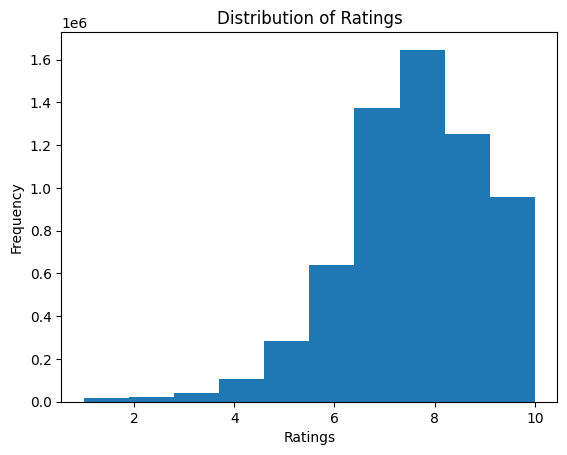

In [ ]:
rating = pd.read_csv(raw_data + "/" + "rating.csv.zip")
# Filter out all ratings less than or equal to 0 and reset the index of the DataFrame

ratingdf = rating[rating.rating>0]

ratingdf = ratingdf.reset_index()

import matplotlib.pyplot as plt

plt.hist(ratingdf['rating'], bins=10)
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.show()

In [ ]:
from scipy.stats import shapiro

stat, p = shapiro(rating['rating'])
print('Shapiro-Wilk test statistic:', stat)
print('p-value:', p)

Shapiro-Wilk test statistic: 0.7877534627914429
p-value: 0.0


c:\Users\Chrisitan\miniconda3\envs\thebridge\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Acordding to the histogram and havnig a p-value of 0.0 indicating the result of the Shapiro-Wilk, we have found strong evidence to reject the null hypothesis that the data is normally distributed.

In this case, we can conclude that the data is not normally distributed. This means that we should consider using a performance metric that is robust to non-normality, such as Mean Absolute Error (MAE).

However, even if the data is not normally distributed, if the goal is to accurately predict the rating, including the few outliers, then it may be better to use RMSE as the evaluation metric, even if the data is not normally distributed. On the other hand, if the goal is to have a model that is robust to outliers and performs well on the majority of the data points, then MAE may be a better choice, even if it does not account for the variability of the data as well as RMSE.

Therefore, we will be using RMSE.

## Evaluating Selected models

We have selected the 4 models with best results in the baseline. Now lets evaluate them doing GridSearchCV and training them to get the results.

- svd = SVD()
- svdp = SVDpp()
- baseonly = BaselineOnly()
- coclus = CoClustering()

In [2]:
# Standard library imports
import os # allows access to OS-dependent functionalities
import sys # to manipulate different parts of the Python runtime environment
import pandas as pd 


# Get the current working directory
cwd = os.getcwd()

# Add the path of the utils directory to sys.path
utils_path = os.path.abspath(os.path.join(cwd, '..', 'utils'))
sys.path.append(utils_path)

# Get the current working directory
cwd = os.getcwd()

# Add the path of the utils directory to sys.path
utils_path = os.path.abspath(os.path.join(cwd, '..', 'utils'))
sys.path.append(utils_path)

# Utils libraries
from cleaning import *
from recommend import *
from testing import *
from training import *

#Preparing folder variables

main_folder = os.path.abspath(os.path.join(os.pardir))
data_folder = (main_folder + "/" +"data")
saved_models_folder = (data_folder + "/" + "saved_models")
raw_data = (data_folder + "/" + "_raw")
processed_data = (data_folder + "/" + "processed")
baseline_data = (saved_models_folder + "/" + "baseline")
test_models = (saved_models_folder + "/" + "test_models")

c:\Users\Chrisitan\AppData\Local\Programs\Python\Python38\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Preparing the data, reducing the sample to 1million rows

In [3]:
def prepare_for_different_models():
    '''
    The code reads two CSV files (anime.csv and rating.csv.zip) and loads them into dataframes. 
    Then it creates a subset of the rating dataframe containing only rows where the rating is 
    greater than 0 and removes the index column. Next, it samples a subset of the data with 
    a specified size, grouped by the rating column.
    '''
    # Load 'anime.csv' file into a pandas DataFrame object called 'anime'
    anime = pd.read_csv(raw_data + "/" + "anime.csv")

    # Load 'rating.csv.zip' file into a pandas DataFrame object called 'rating'
    rating = pd.read_csv(raw_data + "/" + "rating.csv.zip")

    # Create a new DataFrame 'anime_mapping' that is a copy of the 'anime' DataFrame and remove the 'episodes', 'members', and 'rating' columns
    anime_mapping = anime.copy()
    anime_mapping.drop(['episodes','members','rating'],axis=1, inplace=True)

    # Filter out all ratings less than or equal to 0 and reset the index of the DataFrame
    ratingdf = rating[rating.rating>0]
    ratingdf = ratingdf.reset_index()

    # Drop the 'index' column and update the DataFrame in-place
    ratingdf.drop('index', axis=1, inplace=True)

    # Get the shape of the DataFrame 'ratingdf'
    ratingdf.shape

    # Set the size to 1,000,000 and sample from the 'ratingdf' DataFrame based on the proportion of ratings for each score
    size = 1000000

    # This will make sure that the sampled data has roughly the same proportion of ratings for each score as the original data
    ratingdf_sample = ratingdf.groupby("rating", group_keys=False).apply(lambda x: x.sample(int(np.rint(size*len(x)/len(ratingdf))))).sample(frac=1).reset_index(drop=True)

    # Create a new 'Reader' object with the rating scale set to a range between 1 and 10
    reader = Reader(rating_scale=(1,10))

    # Load the sampled data into a 'Dataset' object using the 'load_from_df' method and the 'reader' object
    data = Dataset.load_from_df(ratingdf_sample[['user_id', 'anime_id', 'rating']], reader)

    # Saving the table to pickle
    joblib.dump(data,processed_data + "/" + "data_reader_for_different_models.pkl")

    return data
data = prepare_for_different_models()

### SVD

Singular Value Decomposition (SVD) is a matrix factorization technique used in recommendation systems to reduce the dimensionality of a user-item matrix and identify latent factors that drive user-item interactions. In essence, SVD represents the original matrix as the product of three matrices: a user matrix, a singular value matrix, and an item matrix. The resulting factors can be used to make personalized recommendations by predicting a user's preference for an item based on their past behavior and the behavior of other similar users.

Here are some of the important hyperparameters for the SVD algorithm in the Surprise library:

- **n_factors:** The number of factors to use in the matrix factorization. This controls the number of latent features to be learned from the data.
- **n_epochs:** The number of epochs (iterations) to run the matrix factorization algorithm.
- **biased:** A boolean indicating whether or not to use biases in the model. Biases represent the average rating for each user and item, and can help improve the accuracy of the predictions.
- **lr_all:** The learning rate for all parameters in the model. This controls the step size for each iteration of the optimization algorithm.
- **reg_all:** The regularization strength for all parameters in the model. This helps prevent overfitting by adding a penalty term to the optimization objective that encourages the model to have smaller parameter values.
- **init_mean:** The mean of the Gaussian distribution used to initialize the factor matrices. By default, this is set to 0.
- **init_std_dev:** The standard deviation of the Gaussian distribution used to initialize the factor matrices. By default, this is set to 0.1.

Steps of find_best_svd:
- Define parameter grid for grid search
- Create GridSearchCV object with SVD algorithm
- Fit GridSearchCV object to data
- Print best RMSE and MAE scores, as well as corresponding parameters
- Save model with best parameters
- Save best parameters

In [70]:
def find_best_svd(data):
    '''
    defines a parameter grid for hyperparameter tuning in a collaborative filtering algorithm.
    Then create a GridSearchCV object with the SVD algorithm and a parameter grid consisting 
    of a range of hyperparameters. The GridSearchCV function then performs a grid search on 
    yhe parameter grid to find the best combination of hyperparameters that minimizes the 
    RMSE and MAE scores. The best RMSE and MAE scores and the corresponding parameters 
    are printed out.
    '''
    from surprise import SVD
    from surprise.model_selection import GridSearchCV
    data = data

    # Define parameter grid for grid search
    param_grid = {'n_factors': [50, 100, 150, 300], 
                'n_epochs': [20, 30, 40, 50], 
                'lr_all': [0.002, 0.005, 0.01, 0.1],
                'reg_all': [0.02, 0.05, 0.1]}
    # Create GridSearchCV object with SVD algorithmr
    gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae','mse'], cv=10)

    # Fit GridSearchCV object to data
    gs.fit(data)

    # Print best RMSE and MAE scores, as well as corresponding parameters
    print("Best RMSE score:", gs.best_score['rmse'])
    print("Best MSE score:", gs.best_score['mse'])
    print("Best MAE score:", gs.best_score['mae'])
    print("Best parameters for RMSE:", gs.best_params['rmse'])
    print("Best parameters for MAE:", gs.best_params['mae'])
    print("Best parameters for MSE:", gs.best_params['mse'])
    

    # Save model with best parameters
    joblib.dump(gs,test_models + "/" + "SVD_test_model.pkl")

    # Save best parameters
    joblib.dump(gs.best_params,test_models + "/" + "SVD_best_params_test_model.pkl", compress = 1)

    return gs
best_params = find_best_svd(data)

Best RMSE score: 1.1183239072148927
Best MAE score: 0.8364221843283999
Best parameters for RMSE: {'n_factors': 150, 'n_epochs': 40, 'lr_all': 0.005, 'reg_all': 0.05}
Best parameters for MAE: {'n_factors': 150, 'n_epochs': 40, 'lr_all': 0.005, 'reg_all': 0.05}


### SVDpp

SVD++ is an extension of Singular Value Decomposition (SVD) that takes into account implicit feedback in recommendation systems. In addition to the user-item matrix used in SVD, SVD++ also considers a matrix of implicit feedback such as user interactions with items, item attributes, and user preferences. This additional matrix helps capture the influence of user and item biases on the recommendation process, resulting in more accurate and personalized recommendations. SVD++ also includes a regularization term to avoid overfitting and improve generalization. Overall, SVD++ is a more advanced and sophisticated technique for recommendation systems than SVD.

The SVDpp algorithm in the Surprise library has the following hyperparameters:

- **n_factors:** the number of latent factors. Default is 20.
- **n_epochs:** the number of iterations for the optimization algorithms. Default is 20.
- **lr_all:** the learning rate for all parameters. Default is 0.005.
- **reg_all:** the regularization parameter for all parameters. Default is 0.02.
- **init_mean:** the mean of the normal distribution for factor vectors initialization. Default is 0.
- **init_std_dev:** the standard deviation of the normal distribution for factor vectors initialization. Default is 0.1.
- **verbose:** whether to print details during the optimization process. Default is False.

In [4]:
def find_best_svdpp(data):
    from surprise import SVDpp
    from surprise.model_selection import GridSearchCV
    import joblib

    # Define parameter grid for grid search
    param_grid = {'n_factors': [300], 
                'n_epochs': [20], 
                'lr_all': [0.005],
                'reg_all': [0.1],
                'verbose':[True]}

    # Create GridSearchCV object with SVDpp algorithm
    gs = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae', 'mse'], cv=10)

    # Fit GridSearchCV object to data
    for i, params in enumerate(gs.param_grid):
        print(f"Round {i+1}: {params}")
        gs.fit(data)

    # Print best RMSE and MAE scores, as well as corresponding parameters
    print("Best RMSE score:", gs.best_score['rmse'])
    print("Best MSE score:", gs.best_score['mse'])
    print("Best MAE score:", gs.best_score['mae'])
    print("Best parameters for RMSE:", gs.best_params['rmse'])
    print("Best parameters for MAE:", gs.best_params['mae'])
    print("Best parameters for MSE:", gs.best_params['mse'])

    # Save model with best parameters
    joblib.dump(gs,test_models + "/" + "SVDpp_test_model.pkl")

    # Save best parameters
    joblib.dump(gs.best_params,test_models + "/" + "SVDpp_best_params_test_model.pkl", compress = 1)

    return gs
find_best_svdpp(data)

Round 1: n_factors
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 

### BaselineOnly

BaselineOnly is a simple but effective collaborative filtering algorithm used in recommendation systems. It predicts a user's rating for an item by taking into account the overall average rating of all items, the average rating of the user, and the average rating of the item. These three values are used as baseline estimates, and the difference between the actual rating and the baseline estimate is used as the prediction error. BaselineOnly then learns user and item biases that can improve the accuracy of the baseline estimates. The algorithm is simple and computationally efficient, making it a popular choice for recommendation systems with large datasets. However, it may not capture more complex relationships between users and items compared to more advanced techniques such as matrix factorization.BaselineOnly is a simple but effective collaborative filtering algorithm used in recommendation systems. It predicts a user's rating for an item by taking into account the overall average rating of all items, the average rating of the user, and the average rating of the item. These three values are used as baseline estimates, and the difference between the actual rating and the baseline estimate is used as the prediction error. BaselineOnly then learns user and item biases that can improve the accuracy of the baseline estimates. The algorithm is simple and computationally efficient, making it a popular choice for recommendation systems with large datasets. However, it may not capture more complex relationships between users and items compared to more advanced techniques such as matrix factorization.

The BaselineOnly algorithm in the Surprise library has the following hyperparameters:
- **bsl_options:** a dictionary containing the following options for the baseline estimates:
    - **method:** the method used to compute the baseline estimates. Possible values are: als, sgd. Default is als.
    - **n_epochs:** the number of iterations for the optimization algorithms. Default is 20.
    - **reg_u:** the regularization parameter for users. Default is 15.
    - **reg_i:** the regularization parameter for items. Default is 10.
    - **verbose**: whether to print details during the optimization process. Default is False.
- **biased:** whether to include the baseline estimate in the prediction. Default is True.

In [17]:
def find_best_BaselineOnly(data):
    from surprise import BaselineOnly

    from surprise.model_selection import GridSearchCV
    import joblib

    # Parameters docs and value ranges:
    # http://surprise.readthedocs.io/en/stable/prediction_algorithms.html#baseline-estimates-configuration
    # http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf
 
     # Define parameter grid for grid search

    param_grid = {'bsl_options': {'method': ['sgd', 'als'],
                                'reg': [0.02, 0.05, 0.1],
                                'learning_rate': [0.001, 0.005, 0.01],
                                'n_epochs': [5, 10, 15],
                                'verbose': [True]},
                'verbose': [True]}

    # Create GridSearchCV object with SVDpp algorithm
    gs = GridSearchCV(BaselineOnly, param_grid, measures=['rmse', 'mae','mse'], cv=10)

    # Fit GridSearchCV object to data
    gs.fit(data)

    # Print best RMSE and MAE scores, as well as corresponding parameters
    print("Best RMSE score:", gs.best_score['rmse'])
    print("Best MSE score:", gs.best_score['mse'])
    print("Best MAE score:", gs.best_score['mae'])
    print("Best parameters for RMSE:", gs.best_params['rmse'])
    print("Best parameters for MAE:", gs.best_params['mae'])
    print("Best parameters for MSE:", gs.best_params['mse'])

    # Save model with best parameters
    joblib.dump(gs,test_models + "/" + "BaselineOnly_test_model.pkl")

    # Save best parameters
    joblib.dump(gs.best_params,test_models + "/" + "BaselineOnly_best_params_test_model.pkl", compress = 1)

    
    return gs

find_best_BaselineOnly(data)

- Best RMSE score: 1.5566270718662043
- Best MSE score: 2.426553220392917
- Best MAE score: 1.2098539052864254
- Best parameters for RMSE: {'bsl_options': {'method': 'sgd', 'reg': 0.02, 'learning_rate': 0.01, 'n_epochs': 15, 'verbose': True}, 'verbose': True}
- Best parameters for MAE: {'bsl_options': {'method': 'sgd', 'reg': 0.02, 'learning_rate': 0.01, 'n_epochs': 15, 'verbose': True}, 'verbose': True}
- Best parameters for MSE: {'bsl_options': {'method': 'sgd', 'reg': 0.02, 'learning_rate': 0.01, 'n_epochs': 15, 'verbose': True}, 'verbose': True}

### CoClustering

CoClustering is a collaborative filtering algorithm for recommendation systems that groups users and items into clusters and then estimates the ratings based on the interactions between these clusters. The algorithm tries to find a block diagonal structure in the user-item matrix, where users and items are clustered together. This approach can be more effective than traditional matrix factorization techniques in cases where users or items have similar tastes or properties. The CoClustering algorithm is available in the Surprise library, which is a popular Python library for building and evaluating recommendation systems.

Here's a brief explanation of these hyperparameters:

- **n_cltr_u** and **n_cltr_i:** the number of user and item clusters, respectively. This is a crucial hyperparameter for CoClustering, as it determines the level of granularity of the clustering. Higher values will generally result in better performance but may also increase training time.
- **n_epochs:** the number of epochs or iterations to run the algorithm for. This is also an important hyperparameter, as it determines the number of times the algorithm will iterate over the data. More iterations can lead to better performance but may also increase training time.
- **verbose:** a boolean flag indicating whether or not to print progress messages during training.
- **random_state:** an integer value representing the random seed used to initialize the algorithm's parameters. This can be useful for reproducibility.

In [23]:
# Surprise libraries
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import GridSearchCV, train_test_split, cross_validate
from surprise import CoClustering

In [24]:
def find_best_coclustering(data):


    # Define parameter grid for grid search
    param_grid = {'n_cltr_u': [3, 5, 10], 
                'n_cltr_i': [3, 5, 10], 
                'n_epochs': [20, 30, 40], 
                'verbose': [True, False]
                }

    # Create GridSearchCV object with SVDpp algorithm
    gs = GridSearchCV(CoClustering, param_grid, measures=['rmse', 'mae','mse'], cv=10)

    # Fit GridSearchCV object to data
    gs.fit(data)

    # Print best RMSE and MAE scores, as well as corresponding parameters
    print("Best RMSE score:", gs.best_score['rmse'])
    print("Best MSE score:", gs.best_score['mse'])
    print("Best MAE score:", gs.best_score['mae'])
    print("Best parameters for RMSE:", gs.best_params['rmse'])
    print("Best parameters for MAE:", gs.best_params['mae'])
    print("Best parameters for MSE:", gs.best_params['mse'])

    # Save model with best parameters
    joblib.dump(gs,test_models + "/" + "CoClustering_test_model.pkl")

    # Save best parameters
    joblib.dump(gs.best_params,test_models + "/" + "CoClustering_best_params_test_model.pkl", compress = 1)

    return gs
find_best_coclustering(data)


Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing

- Best RMSE score: 1.3003722013292474
- Best MSE score: 1.6909950754226841
- Best MAE score: 0.9842401168109693
- Best parameters for RMSE: {'n_cltr_u': 3, 'n_cltr_i': 3, 'n_epochs': 30, 'verbose': True}
- Best parameters for MAE: {'n_cltr_u': 3, 'n_cltr_i': 3, 'n_epochs': 30, 'verbose': True}
- Best parameters for MSE: {'n_cltr_u': 3, 'n_cltr_i': 3, 'n_epochs': 30, 'verbose': True}

## Evaluation and training the final selected SVD model

In roder to evaluate, select and train the desired model, we will use 3 different funcions from clening.py, testing.py and testing.py in utils folder:
- supervised_prepare_training
- find_best_svd
- train_test_svd
- svd_precision_recall

In [ ]:
print(supervised_prepare_training.__doc__)

This function is to:
- Load 'anime.csv' file into a pandas DataFrame object called 'anime'
- Load 'rating.csv.zip' file into a pandas DataFrame object called 'rating'
- Create a new DataFrame 'anime_mapping' that is a copy of the 'anime' DataFrame and remove the 'episodes', 'members', and 'rating' columns
- Filter out all ratings less than or equal to 0 and reset the index of the DataFrame
- Drop the 'index' column and update the DataFrame in-place
- Get the shape of the DataFrame 'ratingdf'
- Set the size to 100,000 and sample from the 'ratingdf' DataFrame based on the proportion of ratings for each score
- This will make sure that the sampled data has roughly the same proportion of ratings for each score as the original data
- Create a new 'Reader' object with the rating scale set to a range between 1 and 10
- Load the sampled data into a 'Dataset' object using the 'load_from_df' method and the 'reader' object
- Saving the table to pickle

In [ ]:
supervised_prepare_training() #utils.cleaning

In [9]:
print(find_best_svd.__doc__)

None


Steps of find_best_svd:
- Define parameter grid for grid search
- Create GridSearchCV object with SVD algorithm
- Fit GridSearchCV object to data
- Print best RMSE and MAE scores, as well as corresponding parameters
- Save model with best parameters
- Save best parameters

In [ ]:
find_best_svd() #utils.testing

- Best RMSE score: 1.1020
- Best MAE score:  0.8228
- Best MSE score: 1.2144
- Best parameters for RMSE: {'n_factors': 150, 'n_epochs': 40, 'lr_all': 0.005, 'reg_all': 0.05}
- Best parameters for MAE: {'n_factors': 150, 'n_epochs': 40, 'lr_all': 0.005, 'reg_all': 0.05}
- Best parameters for MSE: {'n_factors': 150, 'n_epochs': 40, 'lr_all': 0.005, 'reg_all': 0.05}

In [ ]:
print(train_test_svd.__doc__)

Steps of train_test_svd:
- Loads the best hyperparameters for the SVD algorithm that were obtained from grid search
- Loads the dataset from a pickle file using joblib
- Splits the data into training and testing sets with a 80:20 ratio
- Creates an instance of the SVD algorithm with the best hyperparameters obtained from grid search
- Trains the SVD algorithm on the training set using the fit() method
- Generates predictions for the test set using the trained model
- Calculates the RMSE and MAE for the predictions
- Saves the trained model as a pickle file using joblib

In [3]:
train_test_svd() #utils.training

RMSE: 1.3757
MAE:  1.0561
RMSE: 1.375737289908081
MAE: 1.056142242807008


In [ ]:
print(svd_precision_recall.__doc__)

In [ ]:
svd_precision_recall()

## Getting recommendations

To get the recommendations we will use the next functions from recommend.py in utils folder:
- sort_it
- create_dict_su
- filtering_and
- filtering_or

In [ ]:
print(sort_it.__doc__)

Steps of sort_it:
- Load the pre-trained SVD model   
- Load the anime dataframe  
- Apply the SVD model to estimate the score for each anime
- Sort the dataframe by the estimated score in descending order and drop the anime_id column
- Create a blank index for the dataframe
- Set the blank index to the dataframe
- Return the sorted dataframe

In [ ]:
print(create_dict_su.__doc__)

Steps of create_dict_su:
- get the final dataframe and the parameters for filtering and number of recommendations to show
- check which method was used to filter the recommendations, 'or' or 'and'
	- filter the dataframe using the OR logic and the given genres and types
	- filter the dataframe using the AND logic and the given genres and types
	- raise an error if an invalid filter type was given     
- select the top n recommendations from the filtered dataframe
- if the filtered dataframe is empty, print a message
	- convert the filtered dataframe to a dictionary
	- return the dictionary of recommendations

In [ ]:
print(filtering_and.__doc__)


    This function takes a DataFrame df, a list of genres, and a list of types as input arguments. 
    The function first creates a boolean mask genre_mask by applying a lambda function to 
    the 'genre' column of the DataFrame. The lambda function checks if the value is a 
    string using isinstance(x, str) and if all genres in the genres list are present 
    in the string, which is split by comma and space using x.split(', '). 
    The all() function returns True if all genres in the genres list are present 
    in the string. The resulting genre_mask will be True for rows where the genre 
    column contains all of the genres in the genres list.

    Then the function creates another boolean mask type_mask by using the isin() 
    method to check if each value in the 'type' column of the DataFrame is in the types list.

    Finally, the function applies both masks to the DataFrame df using the & operator 
    to create a new DataFrame filtered_df that includes only rows where b

Steps of filtering_and:
- This function takes a DataFrame `df`, a list of `genres`, and a list of `types` as input arguments.
- Create a boolean mask that filters rows where the genre column contains all of the genres in the `genres` list.
- Create a boolean mask that filters rows where the type column is in the `types` list.
- Apply both masks to the DataFrame `df` and create a new DataFrame `filtered_df` that includes only rows where both masks are True.
- Return the filtered DataFrame.

In [ ]:
print(filtering_or.__doc__)


    The code defines a function "filtering_or" that filters a pandas dataframe based on user-defined 
    genres and types using an "OR" method. The function allows the user to select one or all possible 
    genres and types and returns a filtered dataframe with the selected genres and types. 
    The function also splits the genre and type columns and explodes them to account for multiple entries.
    


Steps of filtering_or:
- Make a copy of the input DataFrame
- Split the genre column into a list of genres
- Explode the genre column to create a new row for each genre in the list
- If genres are specified and 'ALL' is not one of them, filter the DataFrame to keep only rows where the genre is in the specified list  
- If types are specified and 'ALL' is not one of them, filter the DataFrame to keep only rows where the type is in the specified list
- If both genres and types are specified
- If 'ALL' is in the genres list, set genres to be all the unique genres in the filtered DataFrame
- If 'ALL' is in the types list, set types to be all the unique types in the filtered DataFrame
- Filter the DataFrame to keep only rows where the genre is in the genres list AND the type is in the types list
- Return the filtered DataFrame

In [4]:
# We can get the recommendation as a dictionary
# We input the user ID for we want the recommendations
# Then the genre we want (or write "All" if we shoose "or" filter)
# Then the type we want (or write "All" if we shoose "or" filter)
# We must select a type or filtering, "or"/"and" 
# Then the number of suggestions we have(we might get less if there not so many o none if there is no matches)

create_dict_su(sort_it(25000),["Shounen"],["TV"],"or",10)

[{'name': 'Fullmetal Alchemist: Brotherhood',
  'english_title': 'Fullmetal Alchemist: Brotherhood',
  'japanses_title': '鋼の錬金術師 FULLMETAL ALCHEMIST',
  'genre': 'Shounen',
  'type': 'TV',
  'source': 'Manga',
  'duration': '24 min per ep',
  'episodes': '64',
  'rating': 'R - 17+ (violence & profanity)',
  'score': 9.11,
  'rank': 1.0,
  'members': 793665,
  'synopsis': 'After a horrific alchemy experiment goes wrong in the Elric household, brothers Edward and Alphonse are left in a catastrophic new reality. Ignoring the alchemical principle banning human transmutation, the boys attempted to bring their recently deceased mother back to life. Instead, they suffered brutal personal loss: Alphonse\'s body disintegrated while Edward lost a leg and then sacrificed an arm to keep Alphonse\'s soul in the physical realm by binding it to a hulking suit of armor.\r\n\r\nThe brothers are rescued by their neighbor Pinako Rockbell and her granddaughter Winry. Known as a bio-mechanical engineering 